# Why preferring EM to infer GMM parameters rather than GD ?


In [49]:
import torch
import numpy as np
import matplotlib.pyplot as pl
import seaborn as sns
import scipy
import sklearn
import time
import pandas as pd
from torch.autograd import Variable
sns.set(color_codes=True)
cmap = sns.cubehelix_palette(as_cmap=True, dark=0, light=1, reverse=True)
sns.set_style("whitegrid")
from sklearn.mixture import GaussianMixture as gmm


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Used device: '+device)

!pip install pot
import ot


Used device: cpu


In [50]:
## utilitary functions

def plotGMM(w,m,cov):
  """
  From N. Courty
  """
  mix = gmm(n_components=w.shape[0],covariance_type='full')
  mix.weights_ = w
  mix.means_ = m
  mix.covariances_ = cov
  mix.precisions_cholesky_ = 0
  samples=mix.sample(1000)
  sns.kdeplot(samples[0][:,0],samples[0][:,1], cmap=cmap, n_levels=10, shade=False)


def sample_random_GMM(k, dim, N_pts):
  """
  Generation of ramdom GMM with k nodes, in dimension dim
  Output : Samples from the mixture and its true underlying parameters
  """

  weights = torch.rand(k)
  weights = weights/torch.sum(weights)
  means = torch.rand((k, dim))
  sigma = np.random.randn(k, dim, dim) * 0.6
  covs = sigma@sigma.transpose(0,2,1) ## enforcing covariance matrix to be SDP 
  covs = torch.tensor(covs)
  X = torch.tensor([])

  for i in range(k):
    mean = means[i]
    cov = covs[i]
    sigma_sqrt = torch.tensor(np.real(scipy.linalg.sqrtm(cov))).double()
    pi = weights[i]
    X = torch.cat((X,torch.tensor(scipy.stats.multivariate_normal.rvs(mean=mean, size=int(pi * N_pts))) @ sigma_sqrt))
  return X, means, covs, weights



1.   EM inference


In [52]:
## EM algorithm (sklearn implementation) to infer GMM parameters with fixed number of samples but increasing dimension 

N_pts = 1000
dimensions  = [2,3, 5, 10, 20, 50, 100, 200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
n = len(dimensions)
k = 10
errors_means, errors_covs, errors_weights = torch.zeros(n), torch.zeros(n), torch.zeros(n)
computation_times = np.zeros(n)

for i in range(n) :
  t0 = time.time()
  dim = dimensions[i]
  X, true_means, true_covs,true_weights = sample_random_GMM(k, dim, N_pts) ## generation of GMM samples
  ninit = 1
  gmmX = sklearn.mixture.GaussianMixture(n_components=k, covariance_type='full',n_init=ninit).fit(X) 
  estimated_weights,estimated_means,estimated_covs = gmmX.weights_, gmmX.means_, gmmX.covariances_ ## estimation of
                                                            ## mixture parameters through EM algorithm
  errors_means[i] = torch.linalg.norm(torch.tensor(estimated_means)-true_means, ord=2)**2
  errors_covs[i] = torch.linalg.norm(torch.tensor(estimated_covs)-true_covs)**2
  errors_weights[i] = torch.linalg.norm(torch.tensor(estimated_weights)-true_weights, ord=2)**2

  computation_times[i] = time.time() - t0


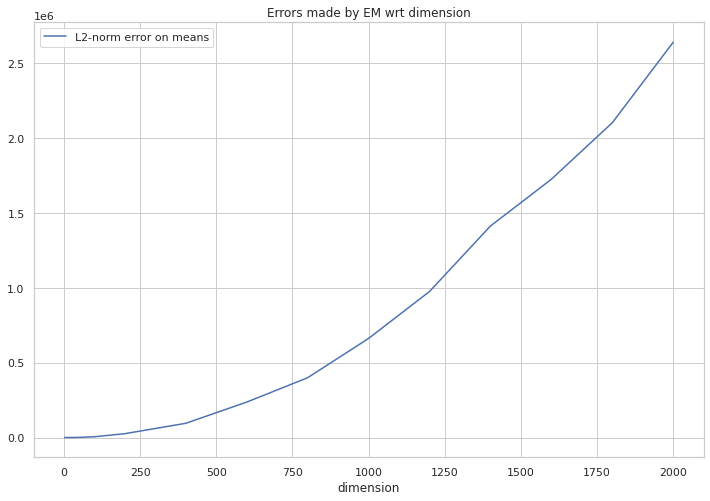

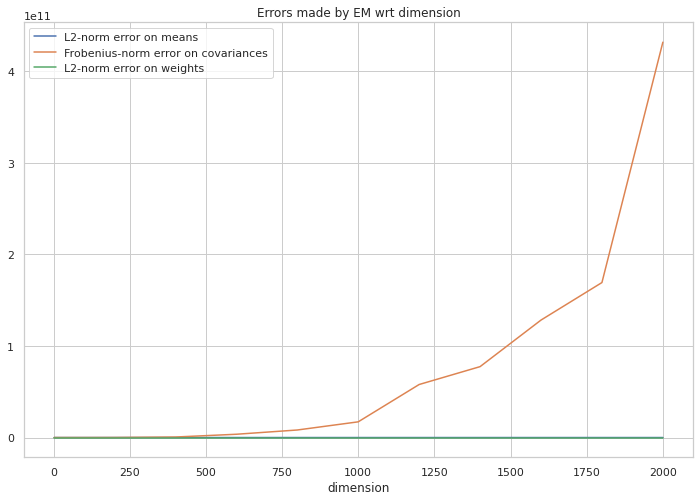

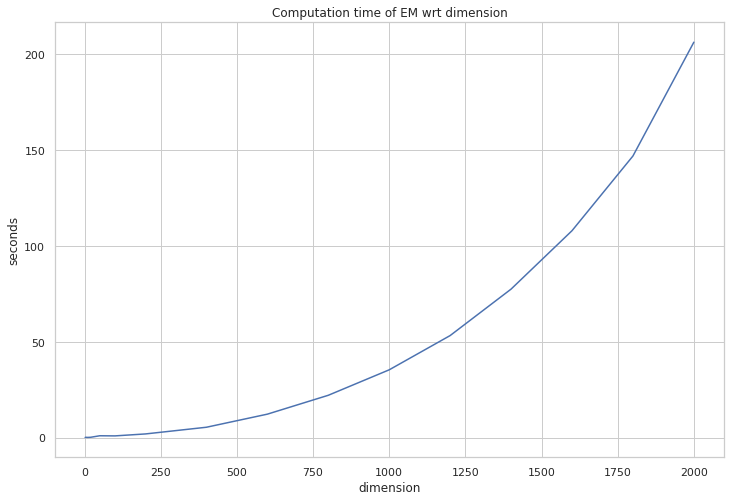

In [55]:
## error plots

pl.figure(figsize=(12,8))
pl.plot(dimensions[:len(errors_means)], errors_means, label='L2-norm error on means')
pl.legend()
pl.title("Errors made by EM wrt dimension")
pl.xlabel('dimension')
pl.show()

pl.figure(figsize=(12,8))
pl.plot(dimensions, errors_means, label='L2-norm error on means')
pl.plot(dimensions, errors_covs, label='Frobenius-norm error on covariances')
pl.plot(dimensions, errors_weights, label='L2-norm error on weights')
pl.legend()
pl.title("Errors made by EM wrt dimension")
pl.xlabel('dimension')
pl.show()

## computation time plots

pl.figure(figsize=(12,8))
pl.plot(dimensions, computation_times)
pl.title("Computation time of EM wrt dimension")
pl.xlabel('dimension')
pl.ylabel('seconds')
pl.show()

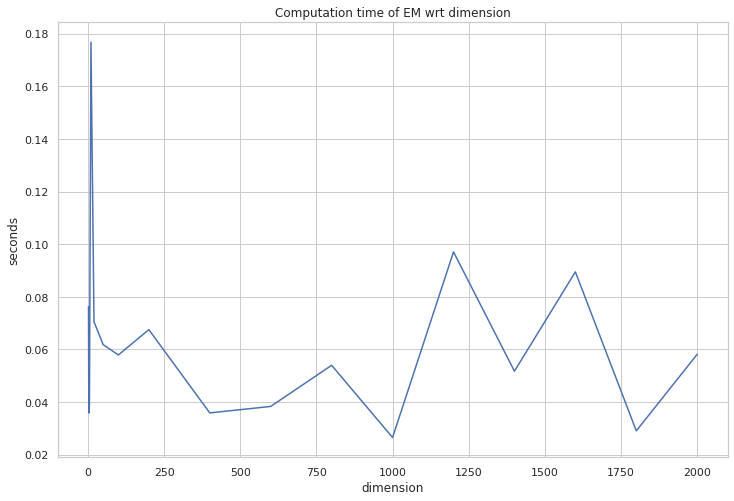

In [54]:
## computation time plots

pl.figure(figsize=(12,8))
pl.plot(dimensions, errors_weights)
pl.title("Computation time of EM wrt dimension")
pl.xlabel('dimension')
pl.ylabel('seconds')
pl.show()

In [15]:
## saving the results in a dataframe
d_EM = {'dimension' : dimensions, 'mean_error': errors_means, 'covariance_error' : errors_covs, 
     'weight_error' : errors_weights, 'computation_time': computation_times}
df_EM = pd.DataFrame(d_EM)
df_EM


,dimension,mean_error,covariance_error,weight_error,computation_time
0,2,1.457147e+01,4.837161e+01,2.257401e-02,0.162247
1,3,3.827159e+01,2.624825e+01,1.922144e-02,0.096828
2,5,8.948102e+00,2.820420e+02,3.729775e-03,0.219157
3,10,2.750374e+01,3.072224e+03,1.334736e-02,0.206526
4,20,1.202733e+02,2.125273e+04,8.436088e-03,0.490216
5,50,9.859048e+02,2.405466e+05,5.626808e-03,0.711621
6,100,5.524860e+03,4.258052e+06,1.444200e-02,0.887047
7,200,2.010222e+04,4.271715e+07,1.495800e-02,2.076228
8,400,9.291524e+04,5.304402e+08,1.540200e-02,5.702806
9,600,2.211326e+05,2.152480e+09,2.220446e-17,12.462113




2.   Gradient descent



In [4]:
epsilon = 1e-15
def log_likelihood(mu, sigma, alpha,X):
    """
    Given GMM parameters and observations X, computes the model log likelihood 
    """
    Sigma = sigma@sigma.permute(0,2,1) ## enforcing SDP, this way the optimization is ≈ unconstrained 
    Y = (X[:,None,:]-mu[None,:,:]) ## shape (N_pts, k, dim)
    Lambda = torch.linalg.inv(Sigma).double() ## shape (k, dim, dim)
    log = torch.einsum("ikp, kpq, ikq -> ik", Y, Lambda, Y) ## shape (N_pts, k)
    constant = torch.sqrt(torch.tensor(2*np.pi))**dim 
    sqrt_determinant = torch.sqrt(torch.abs(torch.linalg.det(Sigma)))
    N_prob = torch.exp(-log/2) / (constant * (sqrt_determinant + epsilon))
    prob = (N_prob * alpha).sum(axis=1)
    return torch.log(prob).sum()


In [18]:
def SGD_estimates(X, k, dim, n_epochs=1000, plot=False,lr = 1e-1):
  """
  Performs a Gradient descent on the GMM parameters, given observed samples
  """

  ## Random initialization 
  X = Variable(X)
  means = Variable(torch.rand((k, dim)), requires_grad=True).type(torch.FloatTensor)
  sigmas = Variable(torch.randn(k, dim, dim), requires_grad=True).type(torch.FloatTensor)
  weights = torch.rand(k)
  weights = Variable(weights/torch.sum(weights), requires_grad=True).type(torch.FloatTensor)

  # gradient flow
  # Defines a SGD optimizer to update the parameters
  optimizer = torch.optim.Adam([means, sigmas, weights], lr=lr)

  losses=[]

  for epoch in range(n_epochs):
      optimizer.zero_grad()

      loss=-log_likelihood(means, sigmas, weights, X)
      if loss == False:
        print("epoch nb ", epoch)
        return
      losses.append(loss.clone().detach().cpu().numpy())
      loss.backward(retain_graph=True)    
      
      optimizer.step()
      
      # project the new weights on the probability simplex
      with torch.no_grad():
        weights = (weights/torch.sum(weights)).type(torch.FloatTensor)

      if plot==True and dim==2 and epoch%1000==0:
        pl.figure(figsize=(8,6))
        plotGMM(weights.detach().numpy(), means.detach().numpy(), (sigmas@sigmas.permute(0,2,1)).detach().numpy())
        pl.title('Epoch ' + str(epoch))
        pl.show()

  if plot==True :
    pl.figure()
    pl.plot(losses)
    pl.title('loss along iterations')
    pl.xlabel("Epoch number")
    pl.show()

  return means.clone().detach(), (sigmas@sigmas.permute(0,2,1)).clone().detach(), weights.clone().detach() ## projection into SDP matrix


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


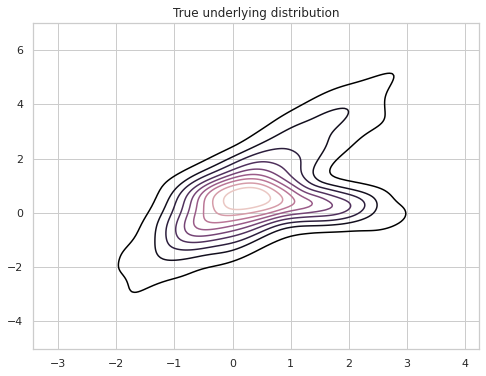

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


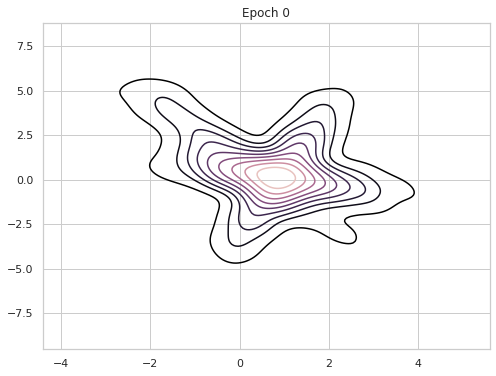

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


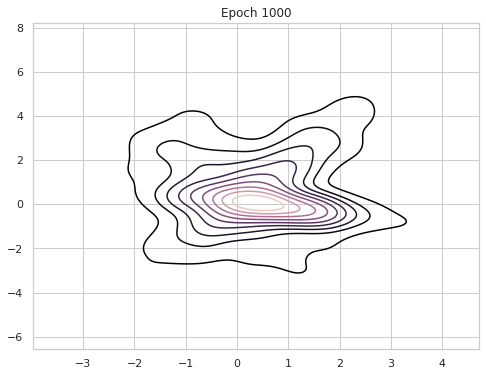

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


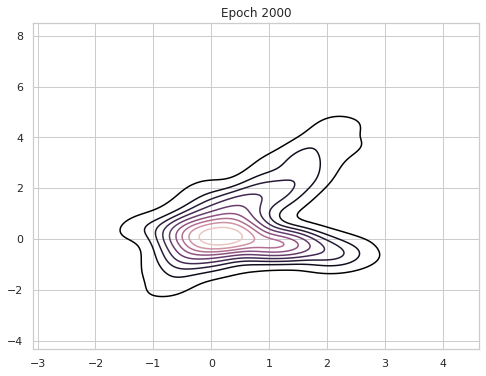

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


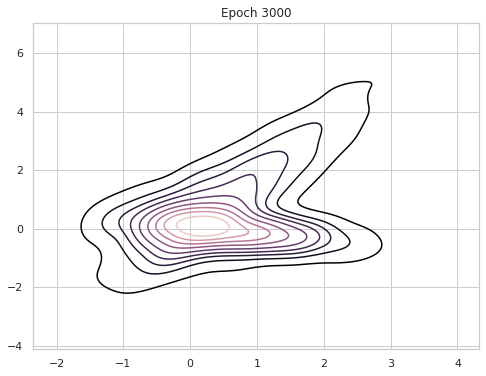

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


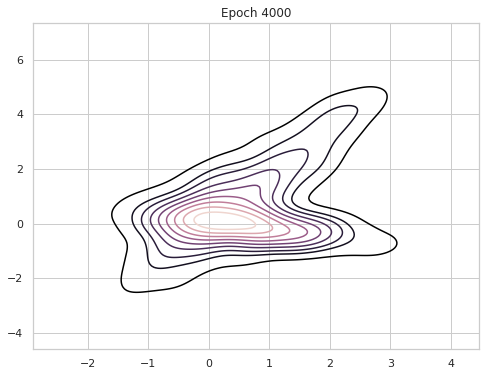

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


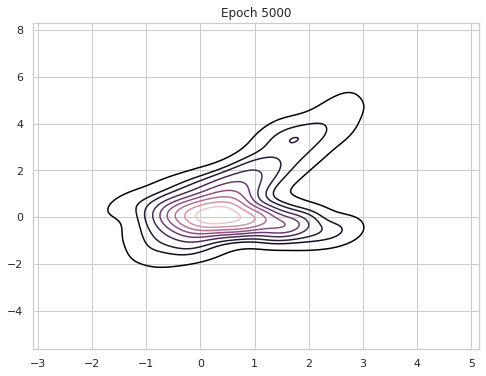

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


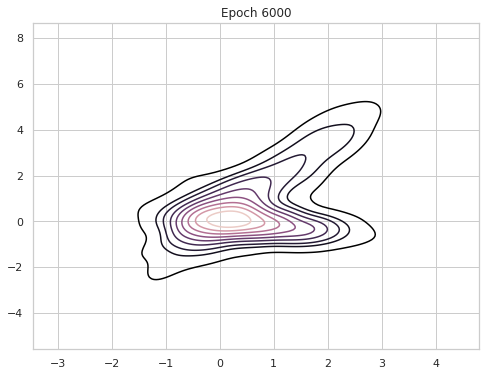

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


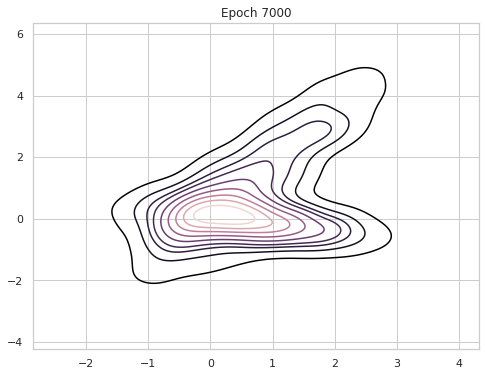

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


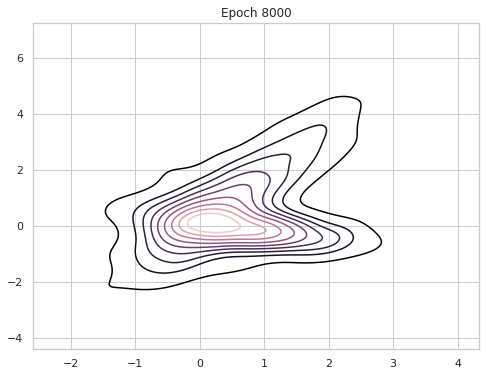

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


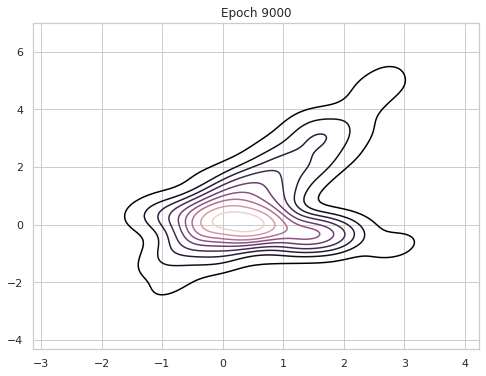

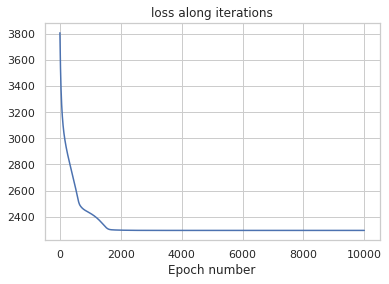

(tensor([[ 0.7249, -0.0892],
         [-0.0563,  0.1654],
         [ 0.8137,  1.4950]]), tensor([[[ 0.7359, -0.2253],
          [-0.2253,  0.0908]],
 
         [[ 0.2657,  0.1040],
          [ 0.1040,  0.6637]],
 
         [[ 0.9848,  1.5655],
          [ 1.5655,  2.9706]]]), tensor([0.4274, 0.2518, 0.3208]))

In [39]:
## example

k=3
dim = 2
N_pts = 1000
# Draw random samples
X, true_means, true_covs, true_weights = sample_random_GMM(k,dim, N_pts)

pl.figure(figsize=(8,6))
plotGMM(true_weights.numpy(), true_means.numpy(), true_covs.numpy())
pl.title("True underlying distribution")
pl.show()

SGD_estimates(X, k, dim, plot=True,n_epochs=10000,lr=1e-3)


In [30]:
## GD algorithm (sklearn implementation) to infer GMM parameters with fixed number of samples but increasing dimension 

dimensions  = np.arange(2,50,2)
n = len(dimensions)
k = 10
N_pts = 1000
errors_means, errors_covs, errors_weights = [],[],[]
computation_times = []

for i in range(n) :
  
  t0 = time.time()
  dim = dimensions[i]
  print("dimension ", dim)

  # Draw random samples
  X, true_means, true_covs, true_weights = sample_random_GMM(k,dim,N_pts)

  estimated_means,estimated_covs,estimated_weights = SGD_estimates(X, k, dim,n_epochs=5000,lr=1e-3) ## estimation of MLE
                                                            ## mixture parameters through Gradient Descent algorithm
  errors_means.append(torch.linalg.norm(estimated_means-true_means, ord=2)**2)
  errors_covs.append(torch.linalg.norm(estimated_covs-true_covs)**2)
  errors_weights.append(torch.linalg.norm(estimated_weights-true_weights, ord=2)**2)

  computation_times.append(time.time() - t0)

dimension  2
dimension  4
dimension  6
dimension  8
dimension  10
dimension  12
dimension  14
dimension  16
dimension  18
dimension  20
dimension  22
dimension  24


RuntimeError: ignored

In [36]:
estimated_means

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, na

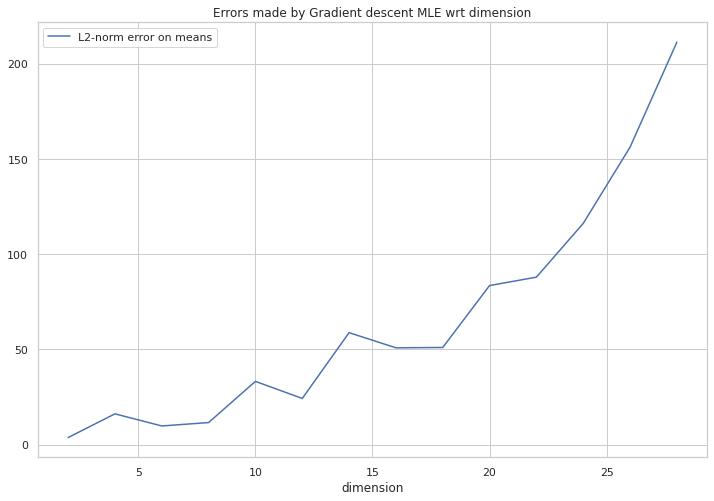

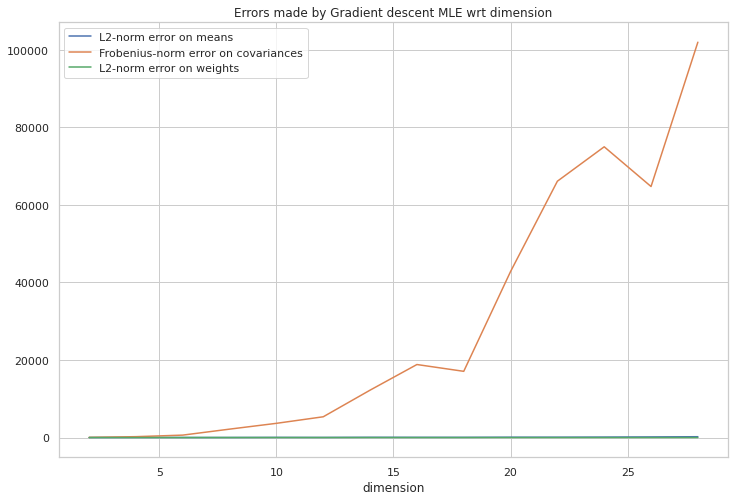

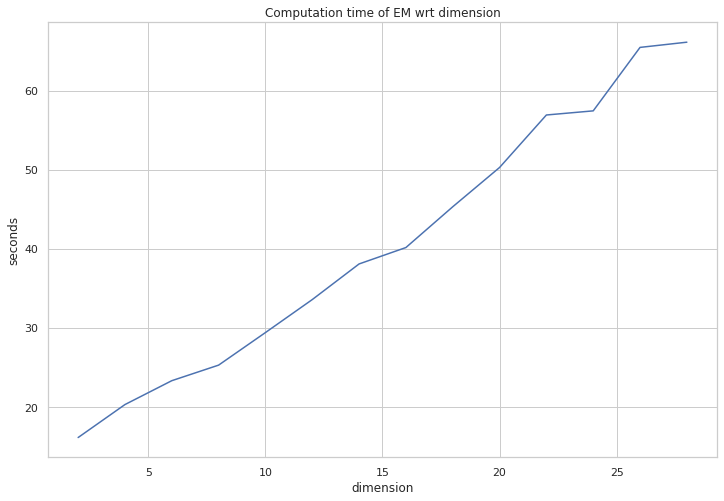

In [48]:
## error plots 
pl.figure(figsize=(12,8))
pl.plot(dimensions[:len(errors_means)], errors_means, label='L2-norm error on means')
pl.legend()
pl.title("Errors made by Gradient descent MLE wrt dimension")
pl.xlabel('dimension')
pl.show()

## another one
pl.figure(figsize=(12,8))
pl.plot(dimensions[:len(errors_means)], errors_means, label='L2-norm error on means')
pl.plot(dimensions[:len(errors_covs)], errors_covs, label='Frobenius-norm error on covariances')
pl.plot(dimensions[:len(errors_weights)], errors_weights, label='L2-norm error on weights')
pl.legend()
pl.title("Errors made by Gradient descent MLE wrt dimension")
pl.xlabel('dimension')
pl.show()

## computation time plot
pl.figure(figsize=(12,8))
pl.plot(dimensions[:len(computation_times)], computation_times)
pl.title("Computation time of EM wrt dimension")
pl.xlabel('dimension')
pl.ylabel('seconds')
pl.show()

In [32]:
## saving the results in a dataframe
d_GD = {'dimension' : dimensions[:len(errors_means)], 'mean_error': errors_means, 'covariance_error' : errors_covs, 
     'weight_error' : errors_weights, 'computation_time': computation_times}
df_GD = pd.DataFrame(d_GD)
df_GD


,dimension,mean_error,covariance_error,weight_error,computation_time
0,2,tensor(3.6754),"tensor(44.2350, dtype=torch.float64)",tensor(0.0156),16.104029
1,4,tensor(16.1148),"tensor(222.8106, dtype=torch.float64)",tensor(0.0265),20.275695
2,6,tensor(9.7503),"tensor(625.1723, dtype=torch.float64)",tensor(0.0484),23.294500
3,8,tensor(11.5444),"tensor(2167.3449, dtype=torch.float64)",tensor(0.0243),25.263566
4,10,tensor(33.1692),"tensor(3663.4937, dtype=torch.float64)",tensor(0.0099),29.382066
5,12,tensor(24.1966),"tensor(5354.6823, dtype=torch.float64)",tensor(0.0201),33.555427
6,14,tensor(58.7467),"tensor(12221.4045, dtype=torch.float64)",tensor(0.0237),38.062714
7,16,tensor(50.7901),"tensor(18828.6042, dtype=torch.float64)",tensor(0.0370),40.137686
8,18,tensor(50.9709),"tensor(17075.3601, dtype=torch.float64)",tensor(0.0257),45.294993
9,20,tensor(83.4855),"tensor(42814.6539, dtype=torch.float64)",tensor(0.0122),50.264055
